# Notebook to reproduce the results analysis, e.g. statistical tests and plots

This notebook re-creates the statistical tests and figures based on the obtained results -- which are present in this directory. The kernel density and run time figures are created as actual figures (.jpg files), the CD diagrams are outputted as Latex's tikz code, hence to actually visualize the figure you must run it in Latex.

This file contains both the time-restricted analysis on the full and the partial OpenML-CC18, and the warm-starting analysis. Read the markdown boxes above code cells carefully for instructions, if no instructions present you can just run the code cell

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from critdd import Diagram
from scipy import stats
from datetime import datetime

### Formatting the already obtained results

Format the metadatabase top 25 in a new .csv file

In [ ]:
df_mdbase = pd.read_csv("metadatabase_aggregated.csv")

def process_logsname_string(s):
    if "AsynchronousSuccessiveHalving" in s:
        return "AsynchronousSuccessiveHalving"
    elif "AsyncEA" in s:
        return "AsyncEA"
    elif "RandomSearch" in s:
        return "RandomSearch"

df_mdbase["logs_name"] = df_mdbase["logs_name"].apply(lambda x : process_logsname_string(x))

logs_names = df_mdbase["logs_name"].unique().tolist()
dataset_ids = df_mdbase["dataset_id"].unique().tolist()

In [ ]:
n_select = 25
df_total = None

for logs_name in logs_names:
    for did in dataset_ids:
        missing_entry_val = min(df_mdbase[(df_mdbase["dataset_id"] == did) & (df_mdbase["score"] < 1000000)]["score"]) - 0.01
        df_learner_dataset = df_mdbase[(df_mdbase["logs_name"] == logs_name) & (df_mdbase["dataset_id"] == did)]
        df_learner_dataset.reset_index(inplace=True, drop=True)
        df_top25 = df_learner_dataset.iloc[[i for i in range(0, min(n_select, len(df_learner_dataset)))]]
        if df_total is None:
            df_total = df_top25
        else:
            df_total = pd.concat([df_total, df_top25])

In [ ]:
df_total = df_total[["logs_name", "dataset_id", "score"]]
df_total.to_csv("mdbase_top25.csv", index=False)

get mdbase data in correct format -- full OpenML18CC

In [ ]:
# for the CD diagram I should still pick only 1 evaluation per meta-learner-dataset

df_mdbase = pd.read_csv("../results_backup/metadatabase_aggregated.csv")

def process_logsname_string(s):
    if "AsynchronousSuccessiveHalving" in s:
        return "AsynchronousSuccessiveHalving"
    elif "AsyncEA" in s:
        return "AsyncEA"
    elif "RandomSearch" in s:
        return "RandomSearch"

df_mdbase["logs_name"] = df_mdbase["logs_name"].apply(lambda x : process_logsname_string(x))

logs_names = df_mdbase["logs_name"].unique().tolist()
dataset_ids = df_mdbase["dataset_id"].unique().tolist()

n_select = 5 # number to select from

idx_to_keep = []
rows_to_add = []
for logs_name in logs_names:
    for did in dataset_ids:
        missing_entry_val = min(df_mdbase[(df_mdbase["dataset_id"] == did) & (df_mdbase["score"] < 1000000)]["score"]) - 0.01
        df_learner_dataset = df_mdbase[(df_mdbase["logs_name"] == logs_name) & (df_mdbase["dataset_id"] == did)]
        df_learner_dataset.reset_index(inplace=True)
        if len(df_learner_dataset) == 0:
            rows_to_add.append([logs_name, did, missing_entry_val])
        else:
            idx_max = df_learner_dataset.iloc[[i for i in range(0, min(n_select, len(df_learner_dataset)))]]["score"].idxmax()
            if not isinstance(idx_max, np.int64):  # no valid entries for the combo
                rows_to_add.append([logs_name, did, missing_entry_val])
            else:
                idx_to_keep.append(df_learner_dataset.iloc[idx_max]["index"])

# select idx and add rows for missing entries
df_top5 = df_mdbase.iloc[idx_to_keep][["logs_name", "dataset_id", "score"]]
n = len(df_mdbase)
for row in rows_to_add:
    df_top5.loc[n] = row
    n += 1

df_top5.to_csv("mdbase_baselines_processed.csv", index=False)

get mdbase data in correct format -- partial OpenML18CC

In [ ]:
# for the CD diagram I should still pick only 1 evaluation per meta-learner-dataset

df_mdbase = pd.read_csv("../results_backup/metadatabase_aggregated.csv")
openmlcc18_subset_dids = [59, 47, 31, 71, 25, 26, 29, 32, 28, 33, 60, 58, 21, 39, 30, 70, 4, 6, 8, 65, 3, 49, 64, 52, 46, 19, 56, 66, 42, 45, 43, 24, 35, 53, 27, 63, 67, 68]
df_mdbase = df_mdbase[df_mdbase["dataset_id"].isin(openmlcc18_subset_dids)]
df_mdbase.reset_index(drop=True, inplace=True)

def process_logsname_string(s):
    if "AsynchronousSuccessiveHalving" in s:
        return "AsynchronousSuccessiveHalving"
    elif "AsyncEA" in s:
        return "AsyncEA"
    elif "RandomSearch" in s:
        return "RandomSearch"

df_mdbase["logs_name"] = df_mdbase["logs_name"].apply(lambda x : process_logsname_string(x))

logs_names = df_mdbase["logs_name"].unique().tolist()
dataset_ids = df_mdbase["dataset_id"].unique().tolist()

n_select = 5 # number to select from

idx_to_keep = []
rows_to_add = []
for logs_name in logs_names:
    for did in dataset_ids:
        missing_entry_val = min(df_mdbase[(df_mdbase["dataset_id"] == did) & (df_mdbase["score"] < 1000000)]["score"]) - 0.01
        df_learner_dataset = df_mdbase[(df_mdbase["logs_name"] == logs_name) & (df_mdbase["dataset_id"] == did)]
        df_learner_dataset.reset_index(inplace=True)
        if len(df_learner_dataset) == 0:
            rows_to_add.append([logs_name, did, missing_entry_val])
        else:
            idx_max = df_learner_dataset.iloc[[i for i in range(0, min(n_select, len(df_learner_dataset)))]]["score"].idxmax()
            if not isinstance(idx_max, np.int64):  # no valid entries for the combo
                rows_to_add.append([logs_name, did, missing_entry_val])
            else:
                idx_to_keep.append(df_learner_dataset.iloc[idx_max]["index"])

# select idx and add rows for missing entries
df_top5 = df_mdbase.iloc[idx_to_keep][["logs_name", "dataset_id", "score"]]
n = len(df_mdbase)
for row in rows_to_add:
    df_top5.loc[n] = row
    n += 1

df_top5.to_csv("mdbase_baselines_processed_partial_openmlcc18.csv", index=False)

get meta-learner data in correct format

In [ ]:
# for the CD diagram I should still pick only 1 evaluation per meta-learner-dataset
df_all = pd.read_csv("time_restricted_results_no_dataset2vec.csv")

metalearners = df_all["metalearner_name"].unique().tolist()
dataset_ids = df_all["dataset_id"].unique().tolist()

n_select = 5 # number to select from

idx_to_keep = []
rows_to_add = []
for metalearner in metalearners:
    for did in dataset_ids:
        # filter out nan with selection: < 1000000
        missing_entry_val = min(df_all[(df_all["dataset_id"] == did) & (df_all["neg_log_loss"] < 1000000)]["neg_log_loss"]) - 0.01
        df_learner_dataset = df_all[(df_all["metalearner_name"] == metalearner) & (df_all["dataset_id"] == did)]
        df_learner_dataset.reset_index(inplace=True)
        if len(df_learner_dataset) == 0:
            rows_to_add.append([metalearner, did, missing_entry_val])
        else:
            idx_max = df_learner_dataset.iloc[[i for i in range(0, min(n_select, len(df_learner_dataset)))]]["neg_log_loss"].idxmax()
            if not isinstance(idx_max, np.int64):  # no valid entries for the combo
                rows_to_add.append([metalearner, did, missing_entry_val])
            else:
                idx_to_keep.append(df_learner_dataset.iloc[idx_max]["index"])

# select idx and add rows for missing entries
df_top5 = df_all.iloc[idx_to_keep]
n = len(df_all)
for row in rows_to_add:
    df_top5.loc[n] = row
    n += 1

df_top5.to_csv("time_restricted_results_no_dataset2vec_processed.csv", index=False)

get meta-learner data in correct format -- subset OpenML-CC18

In [ ]:
# for the CD diagram I should still pick only 1 evaluation per meta-learner-dataset
df_all = pd.read_csv("time_restricted_results.csv")
openmlcc18_subset_dids = [59, 47, 31, 71, 25, 26, 29, 32, 28, 33, 60, 58, 21, 39, 30, 70, 4, 6, 8, 65, 3, 49, 64, 52, 46, 19, 56, 66, 42, 45, 43, 24, 35, 53, 27, 63, 67, 68]
df_all = df_all[df_all["dataset_id"].isin(openmlcc18_subset_dids)]
df_all.reset_index(drop=True, inplace=True)

metalearners = df_all["metalearner_name"].unique().tolist()
dataset_ids = df_all["dataset_id"].unique().tolist()

n_select = 5 # number to select from

idx_to_keep = []
rows_to_add = []
for metalearner in metalearners:
    for did in dataset_ids:
        # filter out nan with selection: < 1000000
        missing_entry_val = min(df_all[(df_all["dataset_id"] == did) & (df_all["neg_log_loss"] < 1000000)]["neg_log_loss"]) - 0.01
        df_learner_dataset = df_all[(df_all["metalearner_name"] == metalearner) & (df_all["dataset_id"] == did)]
        df_learner_dataset.reset_index(inplace=True)
        if len(df_learner_dataset) == 0:
            rows_to_add.append([metalearner, did, missing_entry_val])
        else:
            idx_max = df_learner_dataset.iloc[[i for i in range(0, min(n_select, len(df_learner_dataset)))]]["neg_log_loss"].idxmax()
            if not isinstance(idx_max, np.int64):  # no valid entries for the combo
                rows_to_add.append([metalearner, did, missing_entry_val])
            else:
                idx_to_keep.append(df_learner_dataset.iloc[idx_max]["index"])

# select idx and add rows for missing entries
df_top5 = df_all.iloc[idx_to_keep]
n = len(df_all)
for row in rows_to_add:
    df_top5.loc[n] = row
    n += 1

df_top5.to_csv("time_restricted_results_processed_partial_openmlcc18.csv", index=False)

#### Friedman test, before CD

full OpenML-CC18

In [20]:
results_df = pd.read_csv("time_restricted_results_no_dataset2vec_processed_with_baselines.csv")
results_df["neg_log_loss"] = results_df["neg_log_loss"].astype(float)
groups = []

for metalearner in list(results_df["metalearner_name"].value_counts().index):
    partial_df = results_df[results_df["metalearner_name"] == metalearner]
    groups.append(list(partial_df["neg_log_loss"]))

#perform Friedman Test
stats.friedmanchisquare(*groups)

FriedmanchisquareResult(statistic=53.32856483617894, pvalue=3.600326668073038e-07)

and for OpenML-CC18 subset

In [24]:
results_df = pd.read_csv("time_restricted_results_processed_partial_openmlcc18_with_baselines.csv")
results_df["neg_log_loss"] = results_df["neg_log_loss"].astype(float)
groups = []

for metalearner in list(results_df["metalearner_name"].value_counts().index):
    partial_df = results_df[results_df["metalearner_name"] == metalearner]
    groups.append(list(partial_df["neg_log_loss"]))

#perform Friedman Test
stats.friedmanchisquare(*groups)

FriedmanchisquareResult(statistic=31.762909043642203, pvalue=0.010734488456791922)

#### CD Diagrams for time-restricted analysis

In [ ]:
df = pd.read_csv("time_restricted_results_no_dataset2vec_processed_with_baselines.csv").pivot(
    index = "dataset_id",
    columns = "metalearner_name",
    values = "neg_log_loss"
)

# create a CD diagram from the Pandas DataFrame
diagram = Diagram(
    df.to_numpy(),
    treatment_names = df.columns,
    maximize_outcome = True
)

# inspect average ranks and groups of statistically indistinguishable treatments
diagram.average_ranks # the average rank of each treatment
diagram.get_groups(alpha=.05, adjustment="bonferroni")

# export the diagram to a file
diagram.to_file(
    "cd_full_openmlcc18.tex",
    alpha = .05,
    adjustment = "bonferroni",
    reverse_x = True,
    axis_options = {"title": "critdd"},
)

and for OpenML-CC18 subset

In [ ]:
df = pd.read_csv("time_restricted_results_processed_partial_openmlcc18_with_baselines.csv").pivot(
    index = "dataset_id",
    columns = "metalearner_name",
    values = "neg_log_loss"
)

# create a CD diagram from the Pandas DataFrame
diagram = Diagram(
    df.to_numpy(),
    treatment_names = df.columns,
    maximize_outcome = True
)

# inspect average ranks and groups of statistically indistinguishable treatments
diagram.average_ranks # the average rank of each treatment
diagram.get_groups(alpha=.05, adjustment="bonferroni")

# export the diagram to a file
diagram.to_file(
    "cd_partial_openmlcc18.tex",
    alpha = .05,
    adjustment = "bonferroni",
    reverse_x = True,
    axis_options = {"title": "critdd"},
)

### Computation of the Average Regret and SD of recommended configurations


In [ ]:
df_all = pd.read_csv("time_restricted_results.csv")
metalearner_subset = [mtl_name for mtl_name in df_all["metalearner_name"].unique().tolist() if not "2v" in mtl_name]
df_all = df_all[df_all["metalearner_name"].isin(metalearner_subset)]
df_all.reset_index(drop=True, inplace=True)
df_all.to_csv("time_restricted_results_no_dataset2vec.csv", index=False)

In [27]:
# try out getting the potential score
df = pd.read_csv("time_restricted_results_no_dataset2vec.csv")

metalearners = df["metalearner_name"].unique().tolist()
dataset_ids = df["dataset_id"].unique().tolist()

n_recommendation = 25

def regret(score):
    if score < 100000: # filter out NAN
        return abs(max_score - score) / abs(min_score - max_score)
    return 1

idx_to_keep = []
rows_to_add = []
metalearner_potential = {}
metalearner_std = {}
for metalearner in metalearners:
    metalearner_dataset_potentials = []
    metalearner_dataset_potentials_std = []
    for did in dataset_ids:
        # filter out nan with selection: < 1000000
        missing_entry_val = min(df[(df["dataset_id"] == did) & (df["neg_log_loss"] < 1000000)]["neg_log_loss"]) - 0.01
        df_did = df[df["dataset_id"] == did]
        did_losses_without_nan = [df_did.iloc[i]["neg_log_loss"] for i in range(0, len(df_did)) if df_did.iloc[i]["neg_log_loss"] < 1_000_000] # comparison to exclude nans
        min_score = min(did_losses_without_nan)  
        max_score = max(did_losses_without_nan) 

        df_learner_dataset = df[(df["metalearner_name"] == metalearner) & (df["dataset_id"] == did)]
        df_learner_dataset["potential"] = df_learner_dataset["neg_log_loss"].apply(lambda score: regret(score))

        # fill the remaining spots, without recommendations with worst regret score: 1
        for i in range(len(df_learner_dataset), n_recommendation):
            df_learner_dataset.loc[i] = [metalearner, did, missing_entry_val, 1]
        
        # compute potential for metalearner on this dataset
        metalearner_dataset_potentials.append(df_learner_dataset["potential"].mean())
        metalearner_dataset_potentials_std.append(df_learner_dataset["potential"].std())

    mtl_potential = sum(metalearner_dataset_potentials)/len(metalearner_dataset_potentials)
    mtl_std = sum(metalearner_dataset_potentials_std)/len(metalearner_dataset_potentials_std)
    metalearner_potential[metalearner] = mtl_potential
    metalearner_std[metalearner] = mtl_std
    print(f"metalearner {metalearner} has a potential score of {metalearner_potential}")

In [28]:
metalearner_potential # regret

{'top_similarity_feurer': 0.16017784635739146,
 'top_similarity_wistuba': 0.15592172011028058,
 'xgboostranker_ap_feurer': 0.1684764291297198,
 'xgboostranker_ap_wistuba': 0.2146091551439927,
 'xgboostranker_rankml_feurer': 0.21085652134629312,
 'xgboostranker_rankml_wistuba': 0.17617434907879115,
 'utility_estimate_feurer': 0.1722948778284401,
 'utility_estimate_wistuba': 0.1484469889994486,
 'portfolio_building': 0.14627828950007785,
 'average_rank': 0.10121675270258879}

In [29]:
metalearner_std # standard deviation

{'top_similarity_feurer': 0.13768874296205225,
 'top_similarity_wistuba': 0.1547960476528594,
 'xgboostranker_ap_feurer': 0.056499304302073866,
 'xgboostranker_ap_wistuba': 0.06153346545282709,
 'xgboostranker_rankml_feurer': 0.1942871268784293,
 'xgboostranker_rankml_wistuba': 0.18612464004088683,
 'utility_estimate_feurer': 0.09974627199085537,
 'utility_estimate_wistuba': 0.0941540561310226,
 'portfolio_building': 0.20415415203694143,
 'average_rank': 0.09928104152578915}

and potential scores for OpenML-CC18 subset

In [ ]:
# get the time_restricted_results_partial_openmlcc18.csv
df_all = pd.read_csv("time_restricted_results.csv")
openmlcc18_subset_dids = [59, 47, 31, 71, 25, 26, 29, 32, 28, 33, 60, 58, 21, 39, 30, 70, 4, 6, 8, 65, 3, 49, 64, 52, 46, 19, 56, 66, 42, 45, 43, 24, 35, 53, 27, 63, 67, 68]
df_all = df_all[df_all["dataset_id"].isin(openmlcc18_subset_dids)]
df_all.reset_index(drop=True, inplace=True)
df_all.to_csv("time_restricted_results_partial_openmlcc18.csv", index=False)

In [31]:
# try out getting the potential score
df = pd.read_csv("time_restricted_results_partial_openmlcc18.csv")

metalearners = df["metalearner_name"].unique().tolist()
dataset_ids = df["dataset_id"].unique().tolist()

n_recommendation = 25

def regret(score):
    if score < 100000: # filter out NAN
        return abs(max_score - score) / abs(min_score - max_score)
    return 1

idx_to_keep = []
rows_to_add = []
metalearner_potential = {}
metalearner_std = {}
for metalearner in metalearners:
    metalearner_dataset_potentials = []
    metalearner_dataset_potentials_std = []
    for did in dataset_ids:
        # filter out nan with selection: < 1000000
        missing_entry_val = min(df[(df["dataset_id"] == did) & (df["neg_log_loss"] < 1000000)]["neg_log_loss"]) - 0.01
        df_did = df[df["dataset_id"] == did]
        did_losses_without_nan = [df_did.iloc[i]["neg_log_loss"] for i in range(0, len(df_did)) if df_did.iloc[i]["neg_log_loss"] < 1_000_000] # comparison to exclude nans
        min_score = min(did_losses_without_nan)  
        max_score = max(did_losses_without_nan) 

        df_learner_dataset = df[(df["metalearner_name"] == metalearner) & (df["dataset_id"] == did)]
        df_learner_dataset["potential"] = df_learner_dataset["neg_log_loss"].apply(lambda score: regret(score))

        # fill the remaining spots, without recommendations with worst regret score: 1
        for i in range(len(df_learner_dataset), n_recommendation):
            df_learner_dataset.loc[i] = [metalearner, did, missing_entry_val, 1]
        
        # compute potential for metalearner on this dataset
        metalearner_dataset_potentials.append(df_learner_dataset["potential"].mean())
        metalearner_dataset_potentials_std.append(df_learner_dataset["potential"].std())

    mtl_potential = sum(metalearner_dataset_potentials)/len(metalearner_dataset_potentials)
    mtl_std = sum(metalearner_dataset_potentials_std)/len(metalearner_dataset_potentials_std)
    metalearner_potential[metalearner] = mtl_potential
    metalearner_std[metalearner] = mtl_std
    print(f"metalearner {metalearner} has a potential score of {metalearner_potential}")

In [32]:
# partial openml-cc18 regret
metalearner_potential

{'top_similarity_d2v': 0.18226290627034256,
 'top_similarity_feurer': 0.23252825597525126,
 'top_similarity_wistuba': 0.21197665018374431,
 'xgboostranker_ap_feurer': 0.2268516927052567,
 'xgboostranker_ap_wistuba': 0.29707759352078833,
 'xgboostranker_ap_dataset2vec': 0.1687475527321768,
 'xgboostranker_rankml_feurer': 0.28175320394598297,
 'xgboostranker_rankml_wistuba': 0.22860374355244029,
 'xgboostranker_rankml_dataset2vec': 0.21132119318693854,
 'utility_estimate_feurer': 0.23389223561159175,
 'utility_estimate_wistuba': 0.21169029080793098,
 'utility_estimate_d2v': 0.19756534476986906,
 'portfolio_building': 0.19196537272726372,
 'average_rank': 0.13669146756781111}

In [33]:
# partial openml-cc18 std
metalearner_std

{'top_similarity_d2v': 0.1662313535918369,
 'top_similarity_feurer': 0.16012362679713266,
 'top_similarity_wistuba': 0.18510755872054221,
 'xgboostranker_ap_feurer': 0.0398140153724616,
 'xgboostranker_ap_wistuba': 0.0770623973954724,
 'xgboostranker_ap_dataset2vec': 0.0860755770297066,
 'xgboostranker_rankml_feurer': 0.20021801904638586,
 'xgboostranker_rankml_wistuba': 0.2093452919055586,
 'xgboostranker_rankml_dataset2vec': 0.219371707246684,
 'utility_estimate_feurer': 0.10087028053660126,
 'utility_estimate_wistuba': 0.11651070272169446,
 'utility_estimate_d2v': 0.14526489681173982,
 'portfolio_building': 0.2437241134929638,
 'average_rank': 0.12951834954700994}

### Create Rank distribution plots time-restricted analysis

Full OpenML-CC18

In [34]:
results_df = pd.read_csv("time_restricted_results_no_dataset2vec_processed_with_baselines.csv")
results_df["neg_log_loss"] = results_df["neg_log_loss"].astype(float)

all_ranks = []
for did in results_df["dataset_id"].unique().tolist():
    did_df = results_df[results_df["dataset_id"] == did]
    metalearners_ranked = did_df.sort_values(by="neg_log_loss", ascending=False)["metalearner_name"].to_list()
    dataset_ranks = [(metalearners_ranked[rank - 1], rank) for rank in range(1, len(metalearners_ranked) + 1)]
    all_ranks.append(dataset_ranks)

all_ranks
ranks_per_metalearner = [] # get the ranks now grouped by each meta-learner
metalearner_names = results_df["metalearner_name"].unique().tolist()
for metalearner in metalearner_names:
    metalearner_ranks = []
    for did_ranks in all_ranks:
        for rank_entry in did_ranks:
            if rank_entry[0] == metalearner:
                metalearner_ranks.append(rank_entry[1])
    ranks_per_metalearner.append(metalearner_ranks)

In [35]:
metalearner_names = ['ASHA',
 'RandomSearch',
 'AsyncEA',
 'TopSimilarity-Feurer',
 'TopSimilarity-Wistuba',
 'AP-Feurer',
 'AP-Wistuba',
 'Rankml-Feurer',
 'Rankml-Wistuba',
 'UtilityEstimate-Feurer',
 'UtilityEstimate-Wistuba',
 'PortfolioBuilding',
 'AverageRegret']

C:\Users\leigh\AppData\Local\Temp\ipykernel_15184\1821247661.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(metalearner_names)


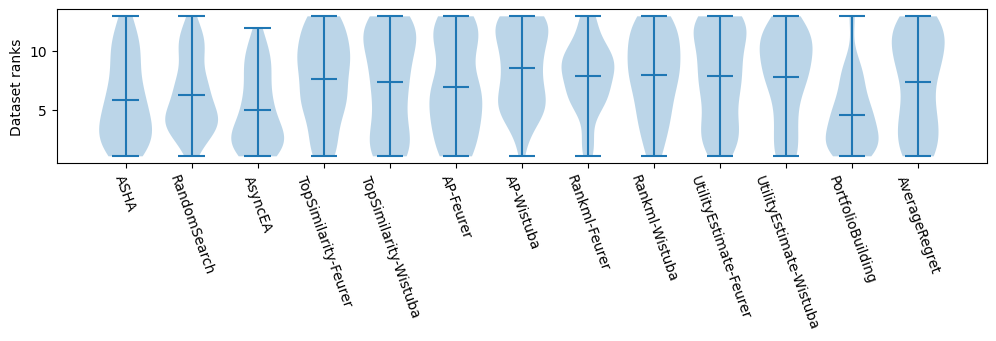

In [36]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(2)

plt.violinplot(ranks_per_metalearner, showmeans=True, widths=0.8) # labels=metalearner_names
ax = plt.gca()
ax.set_ylabel("Dataset ranks")
ax.set_xticklabels(metalearner_names)
ax.set_xticks([i + 1 for i in range(0, len(metalearner_names))])
ax.tick_params(axis='x', labelrotation = -70)

Partial OpenML-CC18

In [48]:
results_df = pd.read_csv("time_restricted_results_processed_with_baselines.csv")
results_df["neg_log_loss"] = results_df["neg_log_loss"].astype(float)

all_ranks = []
for did in results_df["dataset_id"].unique().tolist():
    did_df = results_df[results_df["dataset_id"] == did]
    metalearners_ranked = did_df.sort_values(by="neg_log_loss", ascending=False)["metalearner_name"].to_list()
    dataset_ranks = [(metalearners_ranked[rank - 1], rank) for rank in range(1, len(metalearners_ranked) + 1)]
    all_ranks.append(dataset_ranks)

all_ranks
ranks_per_metalearner = [] # get the ranks now grouped by each meta-learner
metalearner_names = results_df["metalearner_name"].unique().tolist()
for metalearner in metalearner_names:
    metalearner_ranks = []
    for did_ranks in all_ranks:
        for rank_entry in did_ranks:
            if rank_entry[0] == metalearner:
                metalearner_ranks.append(rank_entry[1])
    ranks_per_metalearner.append(metalearner_ranks)

In [51]:
metalearner_names = ['ASHA',
 'RandomSearch',
 'AsyncEA',
 'TopSimilarity-Feurer',
 'TopSimilarity-Wistuba',
 'TopSimilarity-D2V',
 'AP-Feurer',
 'AP-Wistuba',
 'AP-D2V',
 'Rankml-Feurer',
 'Rankml-Wistuba',
 'Rankml-D2V',
 'UtilityEstimate-Feurer',
 'UtilityEstimate-Wistuba',
 'UtilityEstimate-D2V',
 'PortfolioBuilding',
 'AverageRegret']

C:\Users\leigh\AppData\Local\Temp\ipykernel_15184\1821247661.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(metalearner_names)


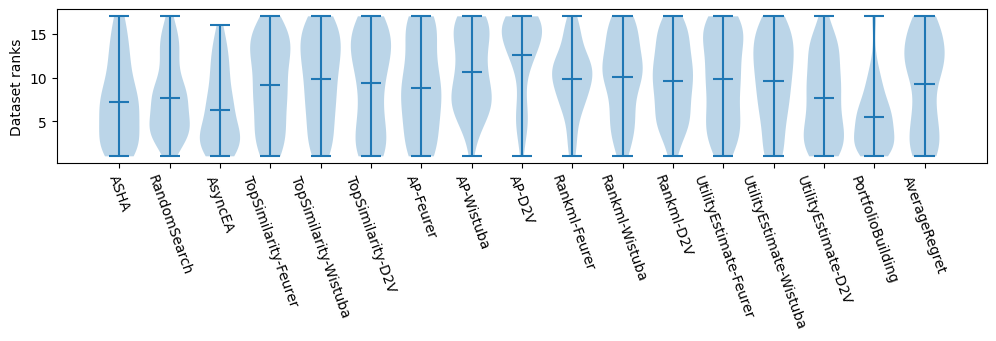

In [52]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(2)

plt.violinplot(ranks_per_metalearner, showmeans=True, widths=0.8) # labels=metalearner_names
ax = plt.gca()
ax.set_ylabel("Dataset ranks")
ax.set_xticklabels(metalearner_names)
ax.set_xticks([i + 1 for i in range(0, len(metalearner_names))])
ax.tick_params(axis='x', labelrotation = -70)

### Timings for the dataset characterizations measures

process the available timings, e.g. get in better format to create plots from it

In [53]:
# process timings
filename = "feurer_timings_raw.txt"
with open(filename) as file:
    lines = [line.rstrip().split(" at ")[1] for line in file]
feurer_datetimes = [datetime.strptime(line, '%Y-%m-%d %H:%M:%S.%f') for line in lines]
feurer_time_difs = [(feurer_datetimes[i + 1] - feurer_datetimes[i]).total_seconds() for i in range(0, len(feurer_datetimes) - 1)]
feurer_dataset_timings = {}
for i, time_dif in enumerate(feurer_time_difs):
    feurer_dataset_timings[i] = time_dif

filename = "wistuba_timings_raw.txt"
with open(filename) as file:
    lines = [line.rstrip().split(" at ")[1] for line in file]
wistuba_datetimes = [datetime.strptime(line, '%Y-%m-%d %H:%M:%S.%f') for line in lines]
wistuba_time_difs = [(wistuba_datetimes[i + 1] - wistuba_datetimes[i]).total_seconds() for i in range(0, len(wistuba_datetimes) - 1)]
wistuba_dataset_timings = {}
for i, time_dif in enumerate(wistuba_time_difs):
    wistuba_dataset_timings[i] = time_dif

filename = "dataset2vec_timings_raw.txt"
with open(filename) as file:
    lines = [line.rstrip().split(" at ")[1] for line in file]
d2v_datetimes = [datetime.strptime(line, '%Y-%m-%d %H:%M:%S.%f') for line in lines]
d2v_time_difs = [(d2v_datetimes[i + 1] - d2v_datetimes[i]).total_seconds() for i in range(0, len(d2v_datetimes) - 1)]
d2v_dataset_timings = {}
for i, time_dif in enumerate(d2v_time_difs):
    d2v_dataset_timings[i] = time_dif

Datasets ordered by samples, features, outcomes. Needed for plots.


In [54]:
# datasets ordered by samples, features, outcomes
did_n_samples =  {71: 500, 31: 522, 50: 540, 59: 540, 36: 569, 41: 583, 2: 625, 11: 690, 5: 699, 21: 736, 48: 748, 14: 768, 26: 797, 25: 841, 18: 846, 17: 958, 23: 990, 12: 1000, 37: 1055, 45: 1080, 58: 1080, 33: 1109, 47: 1372, 28: 1458, 9: 1473, 29: 1563, 40: 1593, 61: 1728, 57: 1941, 3: 2000, 4: 2000, 6: 2000, 7: 2000, 8: 2000, 65: 2000, 32: 2109, 62: 2310, 44: 2534, 42: 2600, 69: 3186, 16: 3190, 0: 3196, 56: 3279, 35: 3751, 22: 3772, 15: 4601, 60: 4839, 70: 5000, 39: 5404, 38: 5456, 54: 5500, 10: 5620, 46: 6118, 20: 6430, 24: 7797, 52: 9873, 53: 10299, 30: 10885, 13: 10992, 49: 11055, 1: 20000, 43: 34465, 64: 44819, 51: 45211, 19: 45312, 34: 48842, 68: 60000, 55: 67557, 27: 70000, 63: 70000, 67: 92000, 66: 96320}
did_n_features =  {2: 4, 26: 4, 47: 4, 48: 4, 39: 5, 60: 5, 7: 6, 61: 6, 64: 6, 14: 8, 19: 8, 5: 9, 9: 9, 17: 9, 41: 10, 23: 12, 71: 12, 34: 14, 11: 15, 1: 16, 13: 16, 51: 16, 18: 18, 21: 19, 62: 19, 12: 20, 59: 20, 70: 20, 30: 21, 31: 21, 32: 21, 33: 21, 66: 21, 38: 24, 57: 27, 22: 29, 36: 30, 49: 30, 52: 32, 0: 36, 20: 36, 28: 37, 29: 37, 50: 39, 54: 40, 37: 41, 55: 42, 8: 47, 46: 51, 15: 57, 16: 61, 6: 64, 10: 64, 25: 70, 44: 72, 4: 76, 58: 81, 43: 118, 69: 180, 3: 216, 65: 240, 40: 256, 42: 500, 53: 561, 24: 617, 27: 784, 63: 784, 45: 856, 67: 1024, 56: 1558, 35: 1776, 68: 3072}
did_n_outcomes =  {0: 2, 5: 2, 11: 2, 12: 2, 14: 2, 15: 2, 17: 2, 19: 2, 22: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 39: 2, 41: 2, 42: 2, 43: 2, 44: 2, 47: 2, 48: 2, 49: 2, 50: 2, 51: 2, 56: 2, 59: 2, 60: 2, 66: 2, 70: 2, 71: 2, 2: 3, 9: 3, 16: 3, 55: 3, 64: 3, 69: 3, 18: 4, 25: 4, 38: 4, 61: 4, 21: 5, 52: 5, 65: 5, 20: 6, 26: 6, 46: 6, 53: 6, 57: 7, 62: 7, 58: 8, 45: 9, 3: 10, 4: 10, 6: 10, 7: 10, 8: 10, 10: 10, 13: 10, 27: 10, 40: 10, 63: 10, 68: 10, 23: 11, 54: 11, 1: 26, 24: 26, 67: 46}

actually create the plot

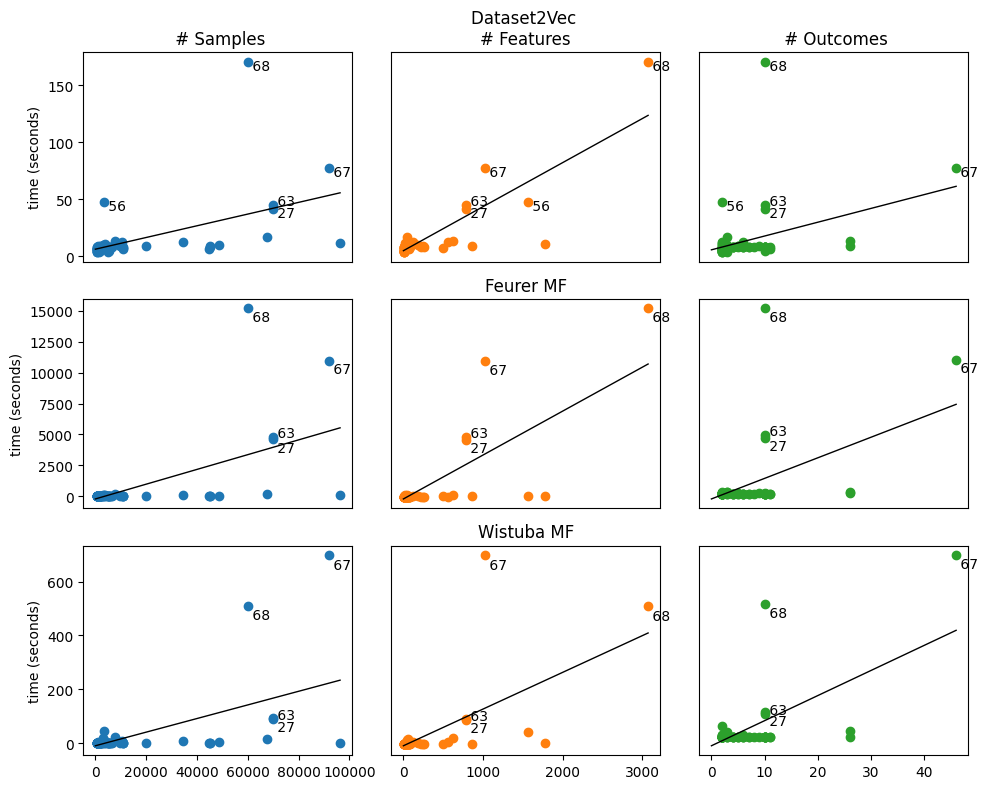

In [55]:
fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(10, 8))

x = np.random.rand(10)
y = np.random.rand(10)
z = np.sqrt(x**2 + y**2)

# D2V n_samples
x = list(did_n_samples.values())
y = [d2v_dataset_timings[did] for did in did_n_samples.keys()]
axs[0, 0].scatter(x, y, color="tab:blue")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[0, 0].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[0, 0].set_xticks([])
for i, id in enumerate(list(did_n_samples.keys())):
    if id == 68 or id == 67 or id == 63 or id == 56 or id == 27:
        if id != 63:
            axs[0, 0].annotate(" " + str(id), (x[i], y[i] - 7))
        else:
            axs[0, 0].annotate(" " + str(id), (x[i], y[i]))
axs[0, 0].set_title("\n # Samples")
axs[0, 0].set_ylabel("time (seconds)")

# D2V n_features
x = list(did_n_features.values())
y = [d2v_dataset_timings[did] for did in did_n_features.keys()]
axs[0, 1].scatter(x, y, color="tab:orange")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[0, 1].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
for i, id in enumerate(list(did_n_features.keys())):
    if id == 68 or id == 67 or id == 63 or id == 56 or id == 27:
        if id != 63:
            axs[0, 1].annotate(" " + str(id), (x[i], y[i] - 7))
        else:
            axs[0, 1].annotate(" " + str(id), (x[i], y[i]))
axs[0, 1].set_title("Dataset2Vec \n# Features")

# D2V n_outcomes
x = list(did_n_outcomes.values())
y = [d2v_dataset_timings[did] for did in did_n_outcomes.keys()]
axs[0, 2].scatter(x, y, color="tab:green")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[0, 2].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[0, 2].set_title("\n # Outcomes")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])
for i, id in enumerate(list(did_n_outcomes.keys())):
    if id == 68 or id == 67 or id == 63 or id == 56 or id == 27:
        if id != 63:
            axs[0, 2].annotate(" " + str(id), (x[i], y[i] - 7))
        else:
            axs[0, 2].annotate(" " + str(id), (x[i], y[i]))

# Feurer n_samples
x = list(did_n_samples.values())
y = [feurer_dataset_timings[did] for did in did_n_samples.keys()]
axs[1, 0].scatter(x, y, color="tab:blue")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[1, 0].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[1, 0].set_xticks([])
for i, id in enumerate(list(did_n_samples.keys())):
    if id == 68 or id == 67 or id == 63 or id == 27:
        if id != 63:
            axs[1, 0].annotate(" " + str(id), (x[i], y[i] - 1000))
        else:
            axs[1, 0].annotate(" " + str(id), (x[i], y[i]))
axs[1, 0].set_ylabel("time (seconds)")

# Feurer n_features
x = list(did_n_features.values())
y = [feurer_dataset_timings[did] for did in did_n_features.keys()]
axs[1, 1].scatter(x, y, color="tab:orange")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[1, 1].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
for i, id in enumerate(list(did_n_features.keys())):
    if id == 68 or id == 67 or id == 63 or id == 27:
        if id != 63:
            axs[1, 1].annotate(" " + str(id), (x[i], y[i] - 1000))
        else:
            axs[1, 1].annotate(" " + str(id), (x[i], y[i]))
axs[1, 1].set_title("Feurer MF")

# Feurer n_outcomes
x = list(did_n_outcomes.values())
y = [feurer_dataset_timings[did] for did in did_n_outcomes.keys()]
axs[1, 2].scatter(x, y, color="tab:green")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])
for i, id in enumerate(list(did_n_outcomes.keys())):
    if id == 68 or id == 67 or id == 63 or id == 27:
        if id != 63:
            axs[1, 2].annotate(" " + str(id), (x[i], y[i] - 1000))
        else:
            axs[1, 2].annotate(" " + str(id), (x[i], y[i]))
axs[1, 2].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line

# Wistuba n_samples
x = list(did_n_samples.values())
y = [wistuba_dataset_timings[did] for did in did_n_samples.keys()]
axs[2, 0].scatter(x, y, color="tab:blue")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[2, 0].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
for i, id in enumerate(list(did_n_samples.keys())):
    if id == 68 or id == 67 or id == 63 or id == 27:
        if id != 63:
            axs[2, 0].annotate(" " + str(id), (x[i], y[i] - 50))
        else:
            axs[2, 0].annotate(" " + str(id), (x[i], y[i]))
axs[2, 0].set_ylabel("time (seconds)")

# Wistuba n_features
x = list(did_n_features.values())
y = [wistuba_dataset_timings[did] for did in did_n_features.keys()]
axs[2, 1].scatter(x, y, color="tab:orange")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[2, 1].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[2, 1].set_yticks([])
for i, id in enumerate(list(did_n_features.keys())):
    if id == 68 or id == 67 or id == 63 or id == 27:
        if id != 63:
            axs[2, 1].annotate(" " + str(id), (x[i], y[i] - 50))
        else:
            axs[2, 1].annotate(" " + str(id), (x[i], y[i]))
axs[2, 1].set_title("Wistuba MF")

# Wistuba n_outcomes
x = list(did_n_outcomes.values())
y = [wistuba_dataset_timings[did] for did in did_n_outcomes.keys()]
axs[2, 2].scatter(x, y, color="tab:green")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[2, 2].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[2, 2].set_yticks([])
for i, id in enumerate(list(did_n_outcomes.keys())):
    if id == 68 or id == 67 or id == 63 or id == 27:
        if id != 63:
            axs[2, 2].annotate(" " + str(id), (x[i], y[i] - 50))
        else:
            axs[2, 2].annotate(" " + str(id), (x[i], y[i]))

plt.tight_layout()
plt.show()

Datasets ordered by samples, features, outcomes. But now excluding the annotated datasets (e.g. the outliers) Needed for plot.

In [56]:
# datasets ordered by samples, features, outcomes
did_n_samples =  {71: 500, 31: 522, 50: 540, 59: 540, 36: 569, 41: 583, 2: 625, 11: 690, 5: 699, 21: 736, 48: 748, 14: 768, 26: 797, 25: 841, 18: 846, 17: 958, 23: 990, 12: 1000, 37: 1055, 45: 1080, 58: 1080, 33: 1109, 47: 1372, 28: 1458, 9: 1473, 29: 1563, 40: 1593, 61: 1728, 57: 1941, 3: 2000, 4: 2000, 6: 2000, 7: 2000, 8: 2000, 65: 2000, 32: 2109, 62: 2310, 44: 2534, 42: 2600, 69: 3186, 16: 3190, 0: 3196, 35: 3751, 22: 3772, 15: 4601, 60: 4839, 70: 5000, 39: 5404, 38: 5456, 54: 5500, 10: 5620, 46: 6118, 20: 6430, 24: 7797, 52: 9873, 53: 10299, 30: 10885, 13: 10992, 49: 11055, 1: 20000, 43: 34465, 64: 44819, 51: 45211, 19: 45312, 34: 48842, 55: 67557, 66: 96320}
did_n_features =  {2: 4, 26: 4, 47: 4, 48: 4, 39: 5, 60: 5, 7: 6, 61: 6, 64: 6, 14: 8, 19: 8, 5: 9, 9: 9, 17: 9, 41: 10, 23: 12, 71: 12, 34: 14, 11: 15, 1: 16, 13: 16, 51: 16, 18: 18, 21: 19, 62: 19, 12: 20, 59: 20, 70: 20, 30: 21, 31: 21, 32: 21, 33: 21, 66: 21, 38: 24, 57: 27, 22: 29, 36: 30, 49: 30, 52: 32, 0: 36, 20: 36, 28: 37, 29: 37, 50: 39, 54: 40, 37: 41, 55: 42, 8: 47, 46: 51, 15: 57, 16: 61, 6: 64, 10: 64, 25: 70, 44: 72, 4: 76, 58: 81, 43: 118, 69: 180, 3: 216, 65: 240, 40: 256, 42: 500, 53: 561, 24: 617, 45: 856, 35: 1776}
did_n_outcomes =  {0: 2, 5: 2, 11: 2, 12: 2, 14: 2, 15: 2, 17: 2, 19: 2, 22: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 39: 2, 41: 2, 42: 2, 43: 2, 44: 2, 47: 2, 48: 2, 49: 2, 50: 2, 51: 2, 59: 2, 60: 2, 66: 2, 70: 2, 71: 2, 2: 3, 9: 3, 16: 3, 55: 3, 64: 3, 69: 3, 18: 4, 25: 4, 38: 4, 61: 4, 21: 5, 52: 5, 65: 5, 20: 6, 26: 6, 46: 6, 53: 6, 57: 7, 62: 7, 58: 8, 45: 9, 3: 10, 4: 10, 6: 10, 7: 10, 8: 10, 10: 10, 13: 10, 40: 10, 23: 11, 54: 11, 1: 26, 24: 26}

Create the plot without the annotated datasets

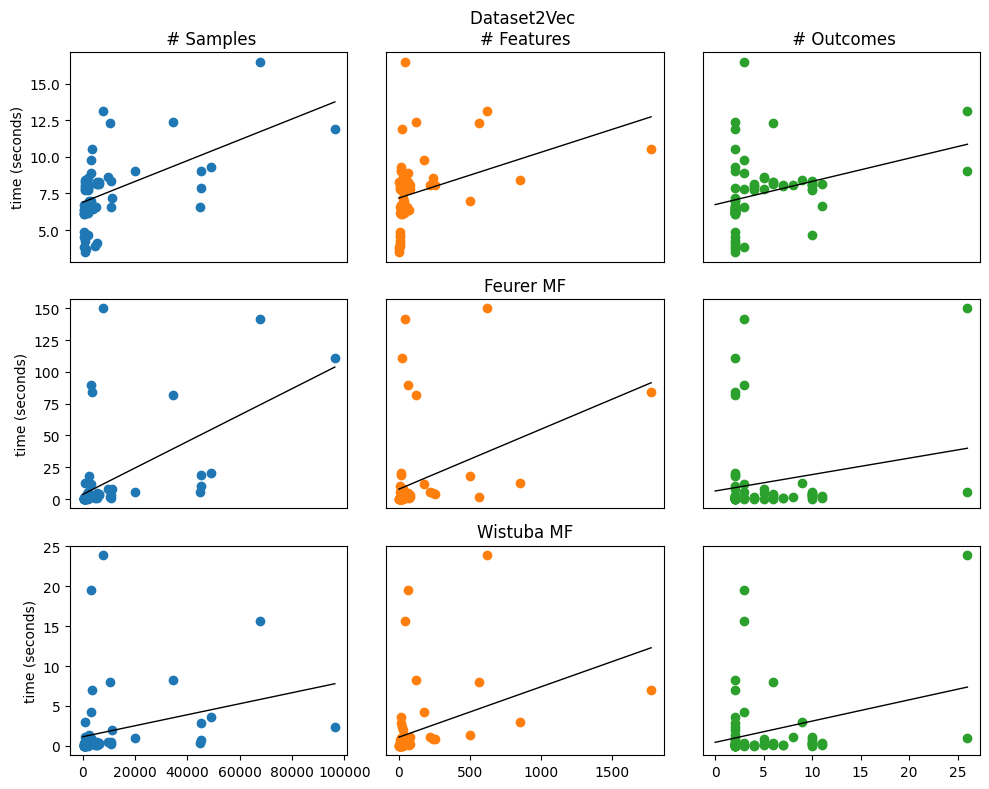

In [57]:
fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(10, 8))

x = np.random.rand(10)
y = np.random.rand(10)
z = np.sqrt(x**2 + y**2)

# D2V n_samples
x = list(did_n_samples.values())
y = [d2v_dataset_timings[did] for did in did_n_samples.keys()]
axs[0, 0].scatter(x, y, color="tab:blue")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[0, 0].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[0, 0].set_xticks([])
for i, id in enumerate(list(did_n_samples.keys())):
    if id == 68 or id == 67 or id == 63 or id == 56 or id == 27:
        if id != 63:
            axs[0, 0].annotate(" " + str(id), (x[i], y[i] - 7))
        else:
            axs[0, 0].annotate(" " + str(id), (x[i], y[i]))
axs[0, 0].set_title("\n # Samples")
axs[0, 0].set_ylabel("time (seconds)")

# D2V n_features
x = list(did_n_features.values())
y = [d2v_dataset_timings[did] for did in did_n_features.keys()]
axs[0, 1].scatter(x, y, color="tab:orange")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[0, 1].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
for i, id in enumerate(list(did_n_features.keys())):
    if id == 68 or id == 67 or id == 63 or id == 56 or id == 27:
        if id != 63:
            axs[0, 1].annotate(" " + str(id), (x[i], y[i] - 7))
        else:
            axs[0, 1].annotate(" " + str(id), (x[i], y[i]))
axs[0, 1].set_title("Dataset2Vec \n# Features")

# D2V n_outcomes
x = list(did_n_outcomes.values())
y = [d2v_dataset_timings[did] for did in did_n_outcomes.keys()]
axs[0, 2].scatter(x, y, color="tab:green")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[0, 2].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[0, 2].set_title("\n # Outcomes")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])
for i, id in enumerate(list(did_n_outcomes.keys())):
    if id == 68 or id == 67 or id == 63 or id == 56 or id == 27:
        if id != 63:
            axs[0, 2].annotate(" " + str(id), (x[i], y[i] - 7))
        else:
            axs[0, 2].annotate(" " + str(id), (x[i], y[i]))

# Feurer n_samples
x = list(did_n_samples.values())
y = [feurer_dataset_timings[did] for did in did_n_samples.keys()]
axs[1, 0].scatter(x, y, color="tab:blue")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[1, 0].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[1, 0].set_xticks([])
for i, id in enumerate(list(did_n_samples.keys())):
    if id == 68 or id == 67 or id == 63 or id == 27:
        if id != 63:
            axs[1, 0].annotate(" " + str(id), (x[i], y[i] - 1000))
        else:
            axs[1, 0].annotate(" " + str(id), (x[i], y[i]))
axs[1, 0].set_ylabel("time (seconds)")

# Feurer n_features
x = list(did_n_features.values())
y = [feurer_dataset_timings[did] for did in did_n_features.keys()]
axs[1, 1].scatter(x, y, color="tab:orange")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[1, 1].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
for i, id in enumerate(list(did_n_features.keys())):
    if id == 68 or id == 67 or id == 63 or id == 27:
        if id != 63:
            axs[1, 1].annotate(" " + str(id), (x[i], y[i] - 1000))
        else:
            axs[1, 1].annotate(" " + str(id), (x[i], y[i]))
axs[1, 1].set_title("Feurer MF")

# Feurer n_outcomes
x = list(did_n_outcomes.values())
y = [feurer_dataset_timings[did] for did in did_n_outcomes.keys()]
axs[1, 2].scatter(x, y, color="tab:green")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])
for i, id in enumerate(list(did_n_outcomes.keys())):
    if id == 68 or id == 67 or id == 63 or id == 27:
        if id != 63:
            axs[1, 2].annotate(" " + str(id), (x[i], y[i] - 1000))
        else:
            axs[1, 2].annotate(" " + str(id), (x[i], y[i]))
axs[1, 2].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line

# Wistuba n_samples
x = list(did_n_samples.values())
y = [wistuba_dataset_timings[did] for did in did_n_samples.keys()]
axs[2, 0].scatter(x, y, color="tab:blue")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[2, 0].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
for i, id in enumerate(list(did_n_samples.keys())):
    if id == 68 or id == 67 or id == 63 or id == 27:
        axs[2, 0].annotate(" " + str(id), (x[i], y[i]))
axs[2, 0].set_ylabel("time (seconds)")

# Wistuba n_features
x = list(did_n_features.values())
y = [wistuba_dataset_timings[did] for did in did_n_features.keys()]
axs[2, 1].scatter(x, y, color="tab:orange")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[2, 1].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[2, 1].set_yticks([])
for i, id in enumerate(list(did_n_features.keys())):
    if id == 68 or id == 67 or id == 63 or id == 27:
        axs[2, 1].annotate(" " + str(id), (x[i], y[i]))
axs[2, 1].set_title("Wistuba MF")

# Wistuba n_outcomes
x = list(did_n_outcomes.values())
y = [wistuba_dataset_timings[did] for did in did_n_outcomes.keys()]
axs[2, 2].scatter(x, y, color="tab:green")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, max(x), num=100)
axs[2, 2].plot(xseq, a + b * xseq, color="k", lw=1) # Plot regression line
axs[2, 2].set_yticks([])
for i, id in enumerate(list(did_n_outcomes.keys())):
    if id == 68 or id == 67 or id == 63 or id == 27:
        axs[2, 2].annotate(" " + str(id), (x[i], y[i]))

plt.tight_layout()
plt.show()

### Results for warm-starting analysis
Can perform these on the full OpenML-CC18 collection because no Dataset2Vec

Friedman test

In [58]:
results_df = pd.read_csv("warm_starting_with_baselines.csv")
results_df["neg_log_loss"] = results_df["neg_log_loss"].astype(float)
groups = []

for metalearner in list(results_df["metalearner_name"].value_counts().index):
    partial_df = results_df[results_df["metalearner_name"] == metalearner]
    groups.append(list(partial_df["neg_log_loss"]))

#perform Friedman Test
stats.friedmanchisquare(*groups)

FriedmanchisquareResult(statistic=67.84453781512607, pvalue=1.2351188524471527e-14)

CD diagram

In [ ]:
df = pd.read_csv("warm_starting_with_baselines.csv").pivot(
    index = "dataset_id",
    columns = "metalearner_name",
    values = "neg_log_loss"
)

# create a CD diagram from the Pandas DataFrame
diagram = Diagram(
    df.to_numpy(),
    treatment_names = df.columns,
    maximize_outcome = True
)

# inspect average ranks and groups of statistically indistinguishable treatments
diagram.average_ranks # the average rank of each treatment
diagram.get_groups(alpha=.05, adjustment="bonferroni")

# export the diagram to a file
diagram.to_file(
    "cd_warm_starting_openmlcc18.tex",
    alpha = .05,
    adjustment = "bonferroni",
    reverse_x = True,
    axis_options = {"title": "critdd"},
)

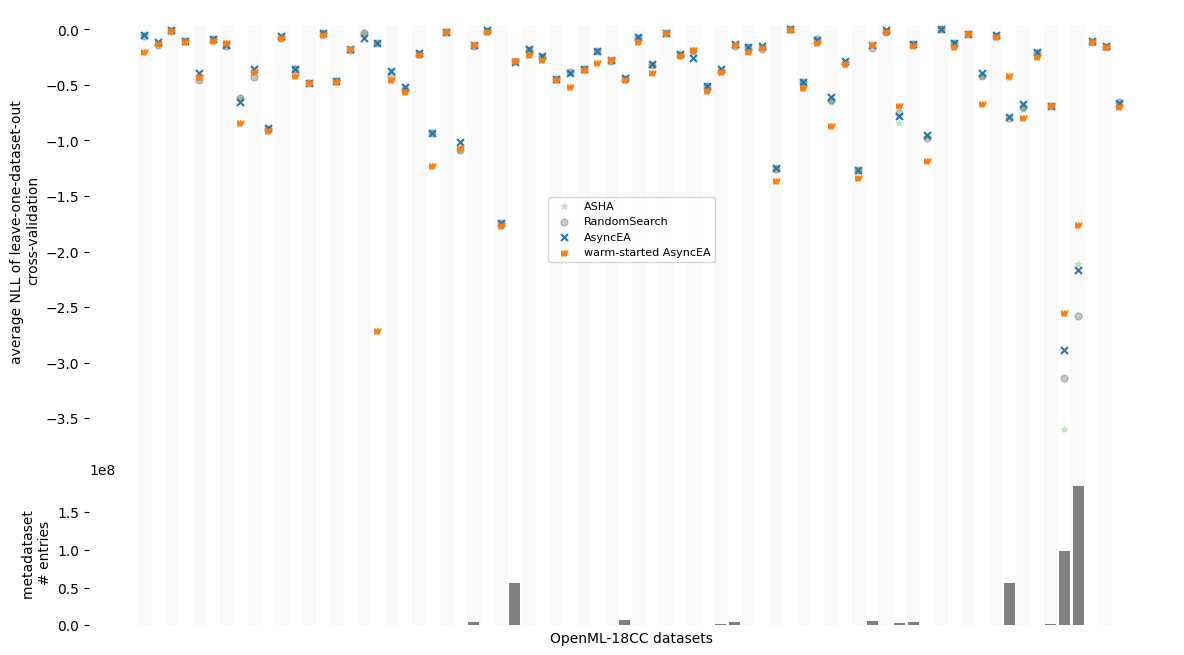

In [59]:
# re-load results everytime because we exclude some results, rerunning would otherwise not yield a good figure
results_df = pd.read_csv("warm_starting_with_baselines.csv")
results_df["neg_log_loss"] = results_df["neg_log_loss"].astype(float)
groups = []

for metalearner in list(results_df["metalearner_name"].value_counts().index):
    partial_df = results_df[results_df["metalearner_name"] == metalearner]
    groups.append(list(partial_df["neg_log_loss"]))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, subplot_kw=dict(frameon=False), figsize=(14, 8), height_ratios=[3, 1]) # frameon=False removes frames

fig.subplots_adjust(hspace=0.1)

# exclude datasets with 58 and 16 because outliers
warm_start_errs = groups[3]
warm_start_errs[58] = None
warm_start_errs[16] = None

# background alternating bars: create the figures as a matrix of pixel values
def alternate(x):
    if x % 2 == 0:
        return 0.98
    return 1
img = [[(alternate(i), alternate(i), alternate(i)) for i in range(0, 72)] for _ in range(0, 50)]
background_ax = plt.axes([0.16, 0.11, 0.705, 0.75]) # create a dummy subplot for the background
background_ax.set_zorder(-1) # set the background subplot behind the others
background_ax.imshow(img, aspect="auto") # show the backgroud image
background_ax.set_xticks([])
background_ax.set_yticks([])
background_ax.axis('off')

datasets = [i for i in range(0, 72)]
ax1.scatter(datasets, groups[0], s=25, c='tab:green', marker="*", alpha=0.2, label='ASHA')
ax1.scatter(datasets, groups[1], s=25, c='black', marker="o", alpha=0.2, label='RandomSearch')
ax1.scatter(datasets, groups[2], s=25, c='tab:blue', marker="x", alpha=1, label='AsyncEA')
ax1.scatter(datasets, groups[3], s=25, c='tab:orange', marker="$W$", alpha=1, label='warm-started AsyncEA')
ax1.legend(fontsize="8", loc="center")
ax1.set_ylabel("average NLL of leave-one-dataset-out \ncross-validation")

# datasets ordered by samples, features, outcomes
did_n_samples =  {71: 500, 31: 522, 50: 540, 59: 540, 36: 569, 41: 583, 2: 625, 11: 690, 5: 699, 21: 736, 48: 748, 14: 768, 26: 797, 25: 841, 18: 846, 17: 958, 23: 990, 12: 1000, 37: 1055, 45: 1080, 58: 1080, 33: 1109, 47: 1372, 28: 1458, 9: 1473, 29: 1563, 40: 1593, 61: 1728, 57: 1941, 3: 2000, 4: 2000, 6: 2000, 7: 2000, 8: 2000, 65: 2000, 32: 2109, 62: 2310, 44: 2534, 42: 2600, 69: 3186, 16: 3190, 0: 3196, 56: 3279, 35: 3751, 22: 3772, 15: 4601, 60: 4839, 70: 5000, 39: 5404, 38: 5456, 54: 5500, 10: 5620, 46: 6118, 20: 6430, 24: 7797, 52: 9873, 53: 10299, 30: 10885, 13: 10992, 49: 11055, 1: 20000, 43: 34465, 64: 44819, 51: 45211, 19: 45312, 34: 48842, 68: 60000, 55: 67557, 27: 70000, 63: 70000, 67: 92000, 66: 96320}
did_n_features =  {2: 4, 26: 4, 47: 4, 48: 4, 39: 5, 60: 5, 7: 6, 61: 6, 64: 6, 14: 8, 19: 8, 5: 9, 9: 9, 17: 9, 41: 10, 23: 12, 71: 12, 34: 14, 11: 15, 1: 16, 13: 16, 51: 16, 18: 18, 21: 19, 62: 19, 12: 20, 59: 20, 70: 20, 30: 21, 31: 21, 32: 21, 33: 21, 66: 21, 38: 24, 57: 27, 22: 29, 36: 30, 49: 30, 52: 32, 0: 36, 20: 36, 28: 37, 29: 37, 50: 39, 54: 40, 37: 41, 55: 42, 8: 47, 46: 51, 15: 57, 16: 61, 6: 64, 10: 64, 25: 70, 44: 72, 4: 76, 58: 81, 43: 118, 69: 180, 3: 216, 65: 240, 40: 256, 42: 500, 53: 561, 24: 617, 27: 784, 63: 784, 45: 856, 67: 1024, 56: 1558, 35: 1776, 68: 3072}
did_n_outcomes =  {0: 2, 5: 2, 11: 2, 12: 2, 14: 2, 15: 2, 17: 2, 19: 2, 22: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 39: 2, 41: 2, 42: 2, 43: 2, 44: 2, 47: 2, 48: 2, 49: 2, 50: 2, 51: 2, 56: 2, 59: 2, 60: 2, 66: 2, 70: 2, 71: 2, 2: 3, 9: 3, 16: 3, 55: 3, 64: 3, 69: 3, 18: 4, 25: 4, 38: 4, 61: 4, 21: 5, 52: 5, 65: 5, 20: 6, 26: 6, 46: 6, 53: 6, 57: 7, 62: 7, 58: 8, 45: 9, 3: 10, 4: 10, 6: 10, 7: 10, 8: 10, 10: 10, 13: 10, 27: 10, 40: 10, 63: 10, 68: 10, 23: 11, 54: 11, 1: 26, 24: 26, 67: 46}
did_evalcounts = {41: 76945, 48: 70066, 2: 56495, 59: 49823, 5: 49360, 14: 48927, 47: 48181, 17: 44684, 31: 42227, 71: 37862, 26: 33786, 25: 24003, 29: 23880, 11: 23492, 9: 18620, 37: 18509, 60: 17997, 18: 17030, 61: 16233, 32: 16084, 28: 15973, 7: 15248, 12: 14719, 58: 14189, 50: 14177, 33: 13991, 23: 13275, 21: 12151, 36: 11939, 15: 11912, 39: 10011, 22: 8252, 30: 7515, 44: 7409, 0: 7112, 57: 6641, 62: 5159, 70: 4456, 4: 4381, 6: 4111, 8: 3890, 49: 3874, 64: 3593, 19: 3280, 38: 3188, 52: 2487, 20: 2395, 10: 2381, 13: 2032, 69: 1872, 51: 1739, 54: 1725, 46: 1630, 65: 1536, 3: 1475, 16: 1465, 40: 1308, 1: 1107, 56: 952, 34: 925, 66: 905, 42: 898, 45: 892, 43: 639, 55: 534, 24: 503, 35: 439, 53: 411, 27: 233, 63: 207, 67: 114, 68: 21}

did_n_values = {}
did_n_evals = {}
datasets_ids = [i for i in range(0, 72)]
for did in datasets_ids:
    did_n_values[did] = did_n_samples[did] * (did_n_features[did] + did_n_outcomes[did])
    did_n_evals[did] = did_evalcounts[did]
ax2.bar(datasets_ids, list(did_n_values.values()), color=["grey" for _ in range(0, len(datasets_ids))])
ax2.set_xticks([]);
ax2.set_ylabel("metadataset \n# entries");
ax2.set_xlabel("OpenML-18CC datasets");

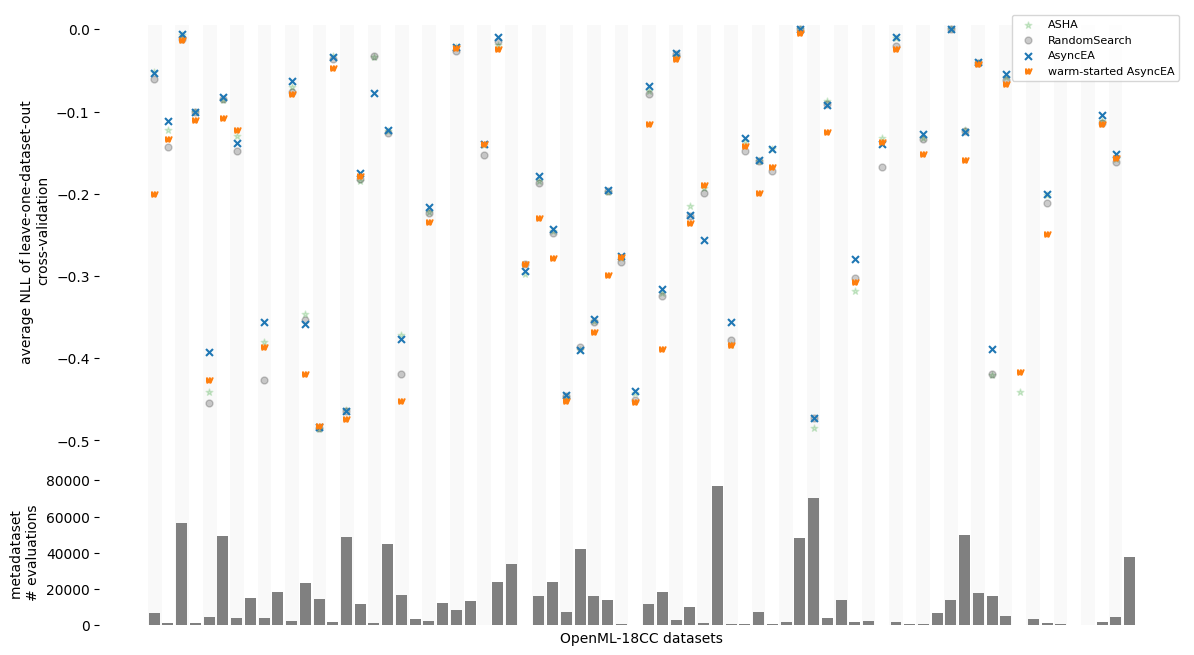

In [60]:
# re-load results everytime because we exclude some results, rerunning would otherwise not yield a good figure
results_df = pd.read_csv("warm_starting_with_baselines.csv")
results_df["neg_log_loss"] = results_df["neg_log_loss"].astype(float)
groups = []

for metalearner in list(results_df["metalearner_name"].value_counts().index):
    partial_df = results_df[results_df["metalearner_name"] == metalearner]
    groups.append(list(partial_df["neg_log_loss"]))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, subplot_kw=dict(frameon=False), figsize=(14, 8), height_ratios=[3, 1]) # frameon=False removes frames

fig.subplots_adjust(hspace=0.1)

# background alternating bars: create the figures as a matrix of pixel values
def alternate(x):
    if x % 2 == 0:
        return 0.98
    return 1
img = [[(alternate(i), alternate(i), alternate(i)) for i in range(0, 72)] for _ in range(0, 50)]
background_ax = plt.axes([0.16, 0.11, 0.705, 0.75]) # create a dummy subplot for the background
background_ax.set_zorder(-1) # set the background subplot behind the others
background_ax.imshow(img, aspect="auto") # show the backgroud image
background_ax.set_xticks([])
background_ax.set_yticks([])
background_ax.axis('off')

# ax2 = fig.add_subplot(212)
# datasets ordered by samples, features, outcomes
did_n_samples =  {71: 500, 31: 522, 50: 540, 59: 540, 36: 569, 41: 583, 2: 625, 11: 690, 5: 699, 21: 736, 48: 748, 14: 768, 26: 797, 25: 841, 18: 846, 17: 958, 23: 990, 12: 1000, 37: 1055, 45: 1080, 58: 1080, 33: 1109, 47: 1372, 28: 1458, 9: 1473, 29: 1563, 40: 1593, 61: 1728, 57: 1941, 3: 2000, 4: 2000, 6: 2000, 7: 2000, 8: 2000, 65: 2000, 32: 2109, 62: 2310, 44: 2534, 42: 2600, 69: 3186, 16: 3190, 0: 3196, 56: 3279, 35: 3751, 22: 3772, 15: 4601, 60: 4839, 70: 5000, 39: 5404, 38: 5456, 54: 5500, 10: 5620, 46: 6118, 20: 6430, 24: 7797, 52: 9873, 53: 10299, 30: 10885, 13: 10992, 49: 11055, 1: 20000, 43: 34465, 64: 44819, 51: 45211, 19: 45312, 34: 48842, 68: 60000, 55: 67557, 27: 70000, 63: 70000, 67: 92000, 66: 96320}
did_n_features =  {2: 4, 26: 4, 47: 4, 48: 4, 39: 5, 60: 5, 7: 6, 61: 6, 64: 6, 14: 8, 19: 8, 5: 9, 9: 9, 17: 9, 41: 10, 23: 12, 71: 12, 34: 14, 11: 15, 1: 16, 13: 16, 51: 16, 18: 18, 21: 19, 62: 19, 12: 20, 59: 20, 70: 20, 30: 21, 31: 21, 32: 21, 33: 21, 66: 21, 38: 24, 57: 27, 22: 29, 36: 30, 49: 30, 52: 32, 0: 36, 20: 36, 28: 37, 29: 37, 50: 39, 54: 40, 37: 41, 55: 42, 8: 47, 46: 51, 15: 57, 16: 61, 6: 64, 10: 64, 25: 70, 44: 72, 4: 76, 58: 81, 43: 118, 69: 180, 3: 216, 65: 240, 40: 256, 42: 500, 53: 561, 24: 617, 27: 784, 63: 784, 45: 856, 67: 1024, 56: 1558, 35: 1776, 68: 3072}
did_n_outcomes =  {0: 2, 5: 2, 11: 2, 12: 2, 14: 2, 15: 2, 17: 2, 19: 2, 22: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 39: 2, 41: 2, 42: 2, 43: 2, 44: 2, 47: 2, 48: 2, 49: 2, 50: 2, 51: 2, 56: 2, 59: 2, 60: 2, 66: 2, 70: 2, 71: 2, 2: 3, 9: 3, 16: 3, 55: 3, 64: 3, 69: 3, 18: 4, 25: 4, 38: 4, 61: 4, 21: 5, 52: 5, 65: 5, 20: 6, 26: 6, 46: 6, 53: 6, 57: 7, 62: 7, 58: 8, 45: 9, 3: 10, 4: 10, 6: 10, 7: 10, 8: 10, 10: 10, 13: 10, 27: 10, 40: 10, 63: 10, 68: 10, 23: 11, 54: 11, 1: 26, 24: 26, 67: 46}
did_evalcounts = {41: 76945, 48: 70066, 2: 56495, 59: 49823, 5: 49360, 14: 48927, 47: 48181, 17: 44684, 31: 42227, 71: 37862, 26: 33786, 25: 24003, 29: 23880, 11: 23492, 9: 18620, 37: 18509, 60: 17997, 18: 17030, 61: 16233, 32: 16084, 28: 15973, 7: 15248, 12: 14719, 58: 14189, 50: 14177, 33: 13991, 23: 13275, 21: 12151, 36: 11939, 15: 11912, 39: 10011, 22: 8252, 30: 7515, 44: 7409, 0: 7112, 57: 6641, 62: 5159, 70: 4456, 4: 4381, 6: 4111, 8: 3890, 49: 3874, 64: 3593, 19: 3280, 38: 3188, 52: 2487, 20: 2395, 10: 2381, 13: 2032, 69: 1872, 51: 1739, 54: 1725, 46: 1630, 65: 1536, 3: 1475, 16: 1465, 40: 1308, 1: 1107, 56: 952, 34: 925, 66: 905, 42: 898, 45: 892, 43: 639, 55: 534, 24: 503, 35: 439, 53: 411, 27: 233, 63: 207, 67: 114, 68: 21}

did_n_values = {}
did_n_evals = {}
datasets_ids = [i for i in range(0, 72)]
for did in datasets_ids:
    did_n_values[did] = did_n_samples[did] * (did_n_features[did] + did_n_outcomes[did])
    did_n_evals[did] = did_evalcounts[did]
ax2.bar(datasets_ids, list(did_n_evals.values()), color=["grey" for _ in range(0, len(datasets_ids))])
ax2.set_xticks([]);
ax2.set_ylabel("metadataset \n# evaluations")
ax2.set_xlabel("OpenML-18CC datasets")

# exclude the values that are smaller than -0.5 for the 2nd scatter plot
asha = groups[0]
for i, val in enumerate(asha):
    if val is not None:
        if val < -0.5:
            asha[i] = None
random = groups[1]
for i, val in enumerate(random):
    if val is not None:
        if val < -0.5:
            random[i] = None
asyncea = groups[2]
for i, val in enumerate(asyncea):
    if val is not None:
        if val < -0.5:
            asyncea[i] = None
warm_start = groups[3]
for i, val in enumerate(warm_start):
    if val is not None:
        if val < -0.5:
            warm_start[i] = None

datasets = [i for i in range(0, 72)]
ax1.scatter(datasets, asha, s=25, c='tab:green', marker="*", alpha=0.2, label='ASHA')
ax1.scatter(datasets, random, s=25, c='black', marker="o", alpha=0.2, label='RandomSearch')
ax1.scatter(datasets, asyncea, s=25, c='tab:blue', marker="x", alpha=1, label='AsyncEA')
ax1.scatter(datasets, warm_start, s=25, c='tab:orange', marker="$W$", alpha=1, label='warm-started AsyncEA')
ax1.set_ylabel("average NLL of leave-one-dataset-out \ncross-validation")
# ax1.set_yscale("symlog")
ax1.legend(fontsize="8");

Convergence Analysis warm-started vs. non-warm-started AsyncEA.

In [61]:
def plot_performances(path_asyncea: str, path_portfolio_asyncea: str, title: str):
    # process timings
    with open(path_asyncea) as file:
        performances_asyncea = [line.split(";")[5].split(",")[0][1:] for line in file][1:]
        performances_asyncea = [float(p) for p in performances_asyncea]
    with open(path_portfolio_asyncea) as file:
        performances_portfolio = [line.split(";")[5].split(",")[0][1:] for line in file][1:]
        performances_portfolio = [float(p) for p in performances_portfolio]
    max_performance_asyncea = [max(performances_asyncea[0:i]) for i in range(1, len(performances_asyncea))]
    max_performance_portfolio = [max(performances_portfolio[0:i]) for i in range(1, len(performances_portfolio))]
    plt.plot(max_performance_asyncea, label="AsyncEA", c="tab:blue")
    plt.plot(max_performance_portfolio, label="warm-started AsyncEA", c="tab:orange")
    plt.legend()
    plt.ylabel("negative logistic loss")
    plt.xlabel("# evaluations")
    plt.xscale("log")
    plt.title(title)

Note: please change the path the `mdbase_path` to the path storing the metadatabase if necessary

In [62]:
cur_dir = os.getcwd()
mdbase_path = os.path.join(str(cur_dir).split("mlta")[0], "mlta/metadatabase_openml18cc") ### ### TODO change this path if necessary TODO ### ###

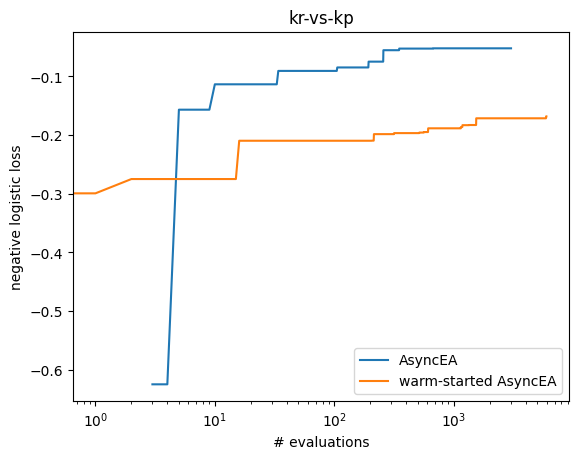

In [63]:
path_asyncea = os.path.join(mdbase_path, "logs/kr-vs-kp_AsyncEA/evaluations.log")
path_portfolio_asyncea = os.path.join(cur_dir, "gama_logs/_d0_f0/evaluations.log")

plot_performances(path_asyncea, path_portfolio_asyncea, "kr-vs-kp")

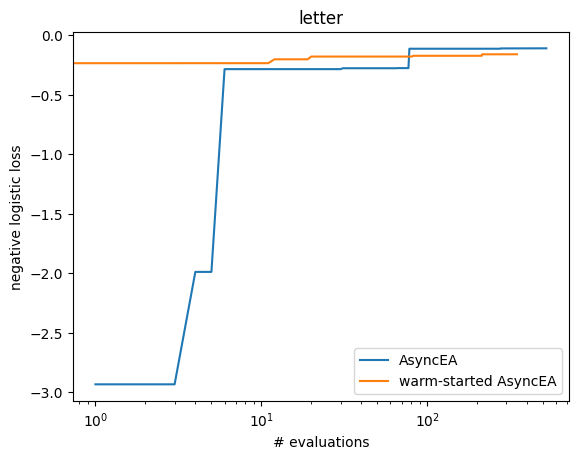

In [64]:
path_asyncea = os.path.join(mdbase_path, "logs/letter_AsyncEA/evaluations.log")
path_portfolio_asyncea = os.path.join(cur_dir, "gama_logs/_d1_f0/evaluations.log")

plot_performances(path_asyncea, path_portfolio_asyncea, "letter")

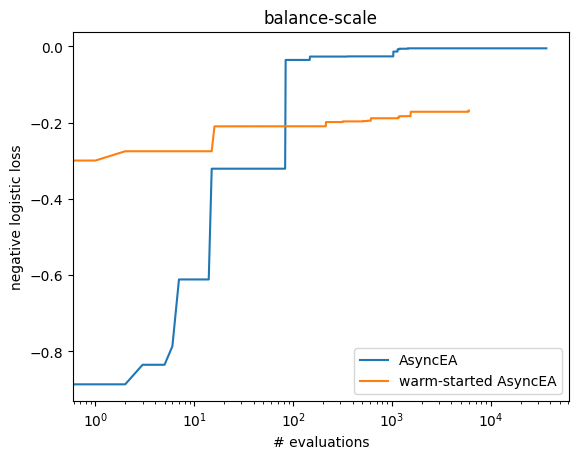

In [65]:
path_asyncea = os.path.join(mdbase_path, "logs/balance-scale_AsyncEA/evaluations.log")
path_portfolio_asyncea = os.path.join(cur_dir, "gama_logs/_d0_f0/evaluations.log")

plot_performances(path_asyncea, path_portfolio_asyncea, "balance-scale")

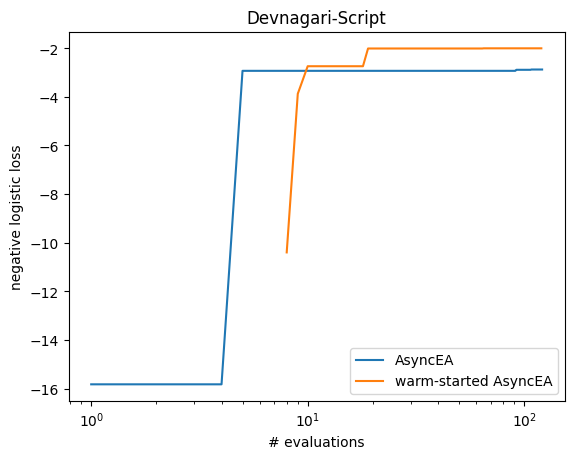

In [66]:
path_asyncea = os.path.join(mdbase_path, "logs/Devnagari-Script_AsyncEA/evaluations.log")
path_portfolio_asyncea = os.path.join(cur_dir, "gama_logs/_d67_f2/evaluations.log")

plot_performances(path_asyncea, path_portfolio_asyncea, "Devnagari-Script")

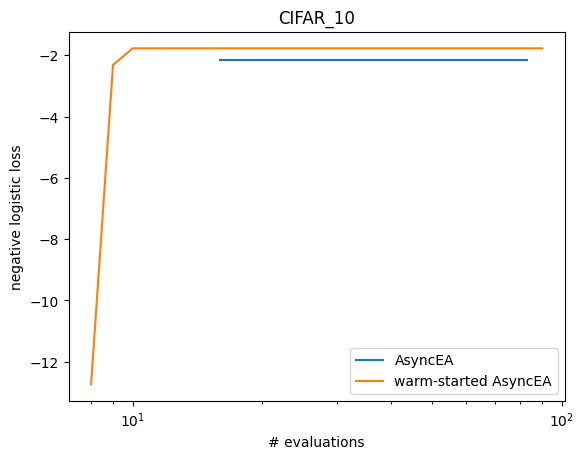

In [67]:
path_asyncea = os.path.join(mdbase_path, "logs/CIFAR_10_AsyncEA/evaluations.log")
path_portfolio_asyncea = os.path.join(cur_dir, "gama_logs/_d68_f0/evaluations.log")

plot_performances(path_asyncea, path_portfolio_asyncea, "CIFAR_10")

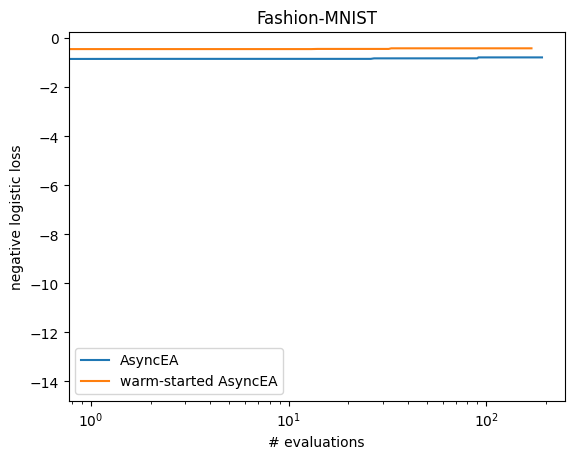

In [68]:
path_asyncea = os.path.join(mdbase_path, "logs/Fashion-MNIST_AsyncEA/evaluations.log")
path_portfolio_asyncea = os.path.join(cur_dir, "gama_logs/_d63_f0/evaluations.log")

plot_performances(path_asyncea, path_portfolio_asyncea, "Fashion-MNIST")

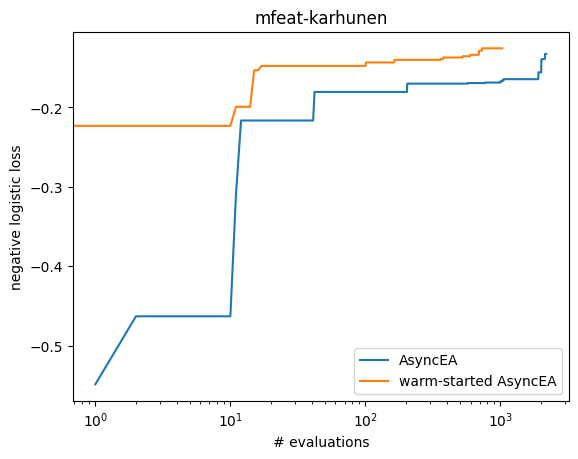

In [69]:
path_asyncea = os.path.join(mdbase_path, "logs/mfeat-karhunen_AsyncEA/evaluations.log")
path_portfolio_asyncea = os.path.join(cur_dir, "gama_logs/_d6_f2/evaluations.log")

plot_performances(path_asyncea, path_portfolio_asyncea, "mfeat-karhunen")

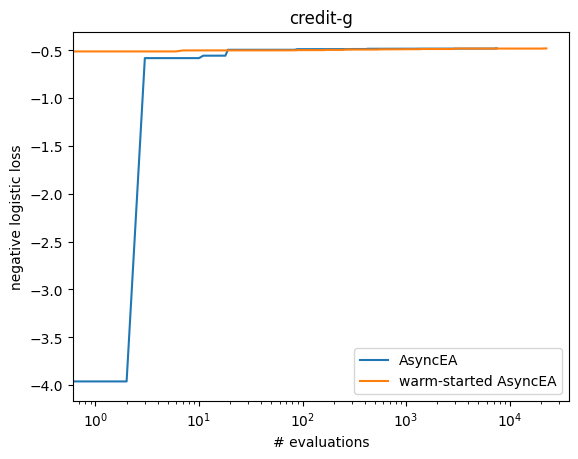

In [70]:
path_asyncea = os.path.join(mdbase_path, "logs/credit-g_AsyncEA/evaluations.log")
path_portfolio_asyncea = os.path.join(cur_dir, "gama_logs/_d12_f1/evaluations.log")

plot_performances(path_asyncea, path_portfolio_asyncea, "credit-g")

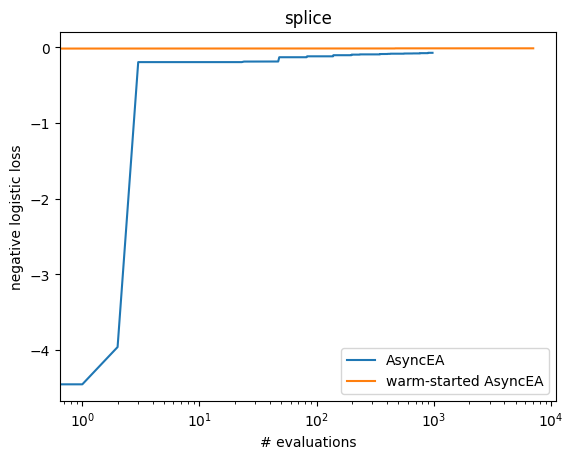

In [71]:
path_asyncea = os.path.join(mdbase_path, "logs/splice_AsyncEA/evaluations.log")
path_portfolio_asyncea = os.path.join(cur_dir, "gama_logs/_d16_f0/evaluations.log")

plot_performances(path_asyncea, path_portfolio_asyncea, "splice")